# Classification example using TabSRALinear: Churn modelling dataset
The dataset contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset.


## Librairies 

In [2]:
pip install skorch-tabsra==0.0.1

In [3]:
import os, sys, time
import numpy as np
import pandas as pd

In [4]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

In [5]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [6]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [7]:
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import EarlyStopping,LRScheduler,Checkpoint, TrainEndCheckpoint, EpochScoring
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split

In [8]:
# import TabSRA
from tabsra.skorch_tabsra import InputShapeSetterTabSRA,TabSRALinearClassifier 

## Data loading, preprocessing and Split

In [10]:
data_path = '../data/'
data = pd.read_csv(data_path+'Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
# remove 'CustomerId','Surname' and use 'RowNumber' as index 
data.set_index('RowNumber', inplace = True)
data.drop(['CustomerId','Surname'], axis=1, inplace=True)

In [12]:
data.Exited.mean(),data.shape

(0.2037, (10000, 11))

### Some statistics 

In [13]:
data.groupby('Geography').agg({'Exited': ['mean','sum', 'count']})

Exited           
               mean  sum count
Geography                     
France     0.161548  810  5014
Germany    0.324432  814  2509
Spain      0.166734  413  2477

The churn rate of customers in Germany (Geography=Germany) is twice
that of other countries

In [14]:
data.groupby('Gender').agg({'Exited': ['mean','sum', 'count']})

Exited            
            mean   sum count
Gender                      
Female  0.250715  1139  4543
Male    0.164559   898  5457

The churn rate is 16% for Gender=Male
and 25%, remaining

In [15]:
data.groupby('Tenure').agg({'Exited': ['mean','sum', 'count']})

Exited           
            mean  sum count
Tenure                     
0       0.230024   95   413
1       0.224155  232  1035
2       0.191794  201  1048
3       0.211100  213  1009
4       0.205258  203   989
5       0.206522  209  1012
6       0.202689  196   967
7       0.172179  177  1028
8       0.192195  197  1025
9       0.216463  213   984
10      0.206122  101   490

The churn rate is not significantly different according to the categories of the feature tenure variable

In [16]:
res = data.groupby('NumOfProducts',as_index=False).agg({'Exited': ['mean','sum', 'count']})
res

NumOfProducts    Exited            
                     mean   sum count
0             1  0.277144  1409  5084
1             2  0.075817   348  4590
2             3  0.827068   220   266
3             4  1.000000    60    60

According to the data, customers
with important number of bank products (NumOfProducts> 2) tend to close their accounts, counter-intuitive?

In [17]:
data.groupby('HasCrCard').agg({'Exited': ['mean','sum', 'count']})

Exited            
               mean   sum count
HasCrCard                      
0          0.208149   613  2945
1          0.201843  1424  7055

Whether the customer has a credit card or not, the churn rate is almost the same.

In [18]:
data.groupby('IsActiveMember').agg({'Exited': ['mean','sum', 'count']})

Exited            
                    mean   sum count
IsActiveMember                      
0               0.268509  1302  4849
1               0.142691   735  5151

In [19]:
data[(data.IsActiveMember==0)&(data.Age>55)&(data.Age<=65)].Exited.mean(),data[(data.IsActiveMember==0)&(data.Age>55)&(data.Age<65)].Exited.count()

(0.9385474860335196, 173)

In [20]:
data[(data.IsActiveMember==1)&(data.Age>55)&(data.Age<65)].Exited.mean(),data[(data.IsActiveMember==1)&(data.Age>55)&(data.Age<65)].Exited.count()

(0.25507246376811593, 345)

Active bank members have less chance of closing their account than the rest of the group.

Moreover, for non-active members of Age between ]55, 65] the churn risk is very high. 

In [21]:
data.drop(['HasCrCard'],axis=1,inplace=True)

### Preprocessing 

In [22]:
data_copy = data#.copy()

In [23]:
data = data_copy.copy()

In [24]:
cat_cols = ['Geography','Gender','IsActiveMember']#
num_cols = ['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']

In [25]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,79084.10,0


In [26]:
feature_names = list(data.columns)
feature_names.pop()

'Exited'

### Split and Process

In [27]:
k =5
Sf= StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
datasets_raw = [(data.iloc[train_index], data.iloc[test_index]) for train_index,test_index in Sf.split(data, data.Exited.values) ]
data_train_df,data_test_df = datasets_raw[0]

In [28]:
data_train_df,data_test_df = datasets_raw[0]

In [29]:
X_train_, X_test_, Y_train_, Y_test_ = data_train_df[feature_names], data_test_df[feature_names],data_train_df.Exited.values,data_test_df.Exited.values

In [30]:
set_config(transform_output="pandas")
processor = ColumnTransformer(
    (
        ("numerical", StandardScaler(), num_cols),
        ("categorical",OneHotEncoder(sparse_output=False, drop="if_binary", handle_unknown="ignore"),cat_cols)
    ),
    verbose_feature_names_out=False,
)


In [31]:
X_train_ = processor.fit_transform(X_train_)

In [32]:
X_test_ = processor.transform(X_test_)

In [33]:
feature_names = list(X_test_.columns)

In [34]:
feature_names

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'IsActiveMember_1']

### Correlation visualization (map)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [36]:
X_train_tmp = X_train_.copy()
X_train_tmp['y'] = Y_train_

/tmp/ipykernel_71321/1798339133.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


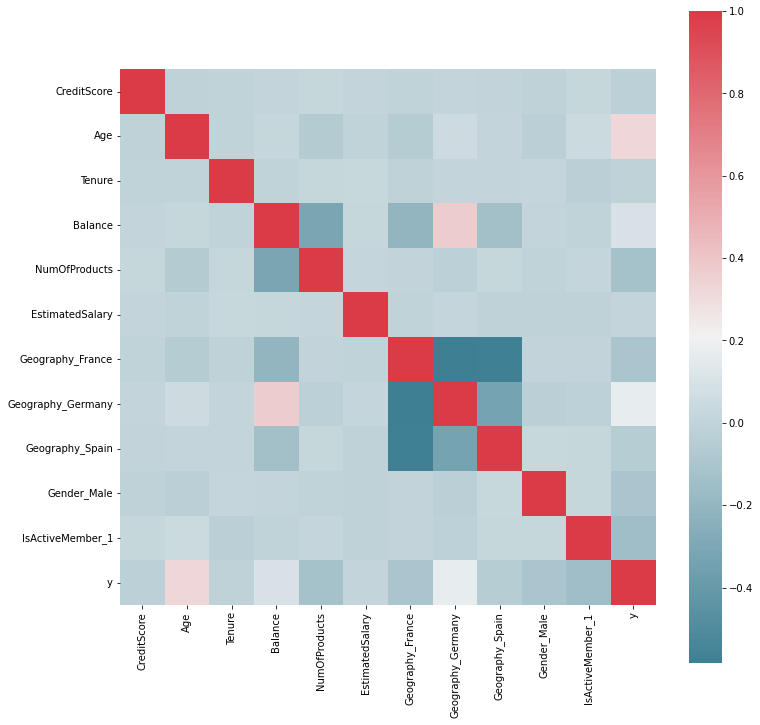

In [37]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 12))
tmp = X_train_tmp.astype(float) 
corr = tmp.corr(method='spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

/tmp/ipykernel_71321/2226804073.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


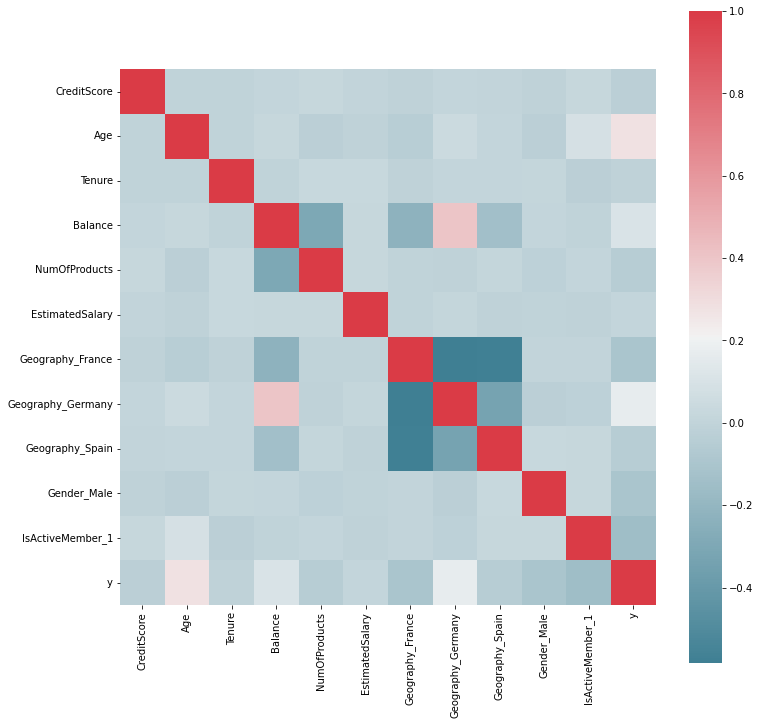

In [38]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 12))
tmp = X_train_tmp.astype(float) 
corr = tmp.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

The feature Age is correlate (positively) to the target variable

In [39]:
## We use only the first fold (ie ind =0)
Y_train_.mean(),Y_test_.mean()

(0.203625, 0.204)

In [40]:
X_test_.shape

(2000, 11)

In [41]:
feature_names.index('NumOfProducts'),feature_names.index('Geography_Germany'),feature_names.index('Balance')

(4, 7, 3)

## Model: TabSRALinear 

In [42]:
## we dont want interactions for categorical features
ind_no_interactions = [feature_names.index(c) for c in ['Geography_France','Geography_Germany','Geography_Spain','Gender_Male','IsActiveMember_1']]

In [44]:
#valid_loss
other_params = {"module__encoder_bias":True,
                "module__classifier_bias":True,
                "module__n_head":1,
                "module__dim_head":8,
                "module__n_hidden_encoder":1,
                "module__dropout_rate":0.3,
                "optimizer__lr":0.009,
                "optimizer__weight_decay":0.0004,
                "random_state":42,
                "criterion": nn.BCEWithLogitsLoss,
                "module__negative_indice":[3,4],
                "module__positive_indice": None,
                "module__no_interaction_indice":ind_no_interactions,
                "max_epochs":500,
                "batch_size":1792,
                "device":'cpu'
               }
scoring = EpochScoring(scoring='roc_auc',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=False)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=50,load_best=True,lower_is_better=False, threshold=0.0001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=25, min_lr=2e-5,factor=0.2, verbose=1)
call_b = [scoring, setter, early_stop, lr_scheduler]

In [45]:
Y_test_.shape

(2000,)

In [46]:
%%time
valid_dataset = Dataset(X_test_.values.astype(np.float32),Y_test_.astype(np.float32))
TabSRAClassifier = TabSRALinearClassifier(**other_params,train_split = predefined_split(valid_dataset),callbacks = call_b)#,
_ = TabSRAClassifier.fit(X_train_.values.astype(np.float32),Y_train_.astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    roc_auc    train_loss    valid_acc    valid_loss      dur
-------  ---------  ------------  -----------  ------------  -------
      1     0.5926        0.6676       0.6895        0.6378  13.5672
      2     0.6384        0.6190       0.7690        0.5907  0.0608
      3     0.6732        0.5725       0.7895        0.5472  0.0580
      4     0.6918        0.5320       0.8005        0.5137  0.0595
      5     0.7049        0.5026       0.7990        0.4909  0.0619
      6     0.7226        0.4823       0.8015        0.4745  0.0599
      7     0.7427        0.4679       0.8060        0.4614  0.0582
      8     0.7628        0.4560       0.8130        0.4498  0.0808
      9     0.7812        0.4454       0.8165        0.4395  0.0802
     10     0.7941        0.4364       0.8220        0.4311  0.0792
     11     0.8035 

In [47]:
with open("BankChurn_v1_hidden1.pkl", "wb") as f:
    pickle.dump(TabSRAClassifier, f)


In [48]:
with open("BankChurn_v1_hidden1.pkl", "rb") as f:
    TabSRAClassifier = pickle.load(f)

In [49]:
Coef  = pd.DataFrame(TabSRAClassifier.get_weights()[0])
Coef = Coef.T
Coef.columns=feature_names
Coef

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,IsActiveMember_1
0,-0.339903,2.686546,-0.087278,0.0,-2.733543,0.293018,-0.427481,0.413826,-0.37576,-0.471421,-0.648319


In [50]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
pred_tabsra = TabSRAClassifier.predict_proba(X_test_.values.astype(np.float32))

best_aucroc = roc_auc_score(Y_test_, pred_tabsra[:,1]) 
best_aurpr = average_precision_score(Y_test_, pred_tabsra[:,1]) 
print(f"--AUCROC perf = {best_aucroc} -- AUCPR perf = {best_aurpr}")

--AUCROC perf = 0.8534061237560351 -- AUCPR perf = 0.6540729992712888


**Now let's compare the achieve performance with a well tuned XGBoost model**

## Model: XGBoost 

In [51]:
from xgboost import XGBClassifier
import xgboost as xgb

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [52]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBClassifier(**config_opt)
    return model_xgb

In [53]:
constraints  = [0 for i in range(11)]
constraints[feature_names.index('NumOfProducts')]=-1
constraints[feature_names.index('Balance')]=-1

constraints = tuple(constraints)
constraints

(0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0)

In [54]:
X_test_.shape

(2000, 11)

In [55]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.01,#0.08847826679705378,
              'max_depth': 3,
              'colsample_bytree': 0.7,
              'subsample': 1.0,
              'n_estimators': 1400,#1400 ,184
              'min_child_weight':1,
              'monotone_constraints':str(constraints),
               'eval_metric':['auc']
              }
static_params_xgb = {
                 'random_state':42,
                 'objective': 'binary:logistic',
                 'n_jobs': -1,
}


In [56]:
%%time
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_train_.values, Y_train_),(X_test_.values, Y_test_)]
model_xgb.fit(X_train_.values, Y_train_, eval_metric=['auc'], eval_set=eval_set, verbose=0,early_stopping_rounds=100)

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 34.3 s, sys: 281 ms, total: 34.6 s
Wall time: 2.25 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eta=0.01, eval_metric=['auc'], gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0)',
              n_estimators=1400, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [57]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict_proba(X_test_)[:,1]
best_aucroc_xgb = roc_auc_score(Y_test_, pred_xgboost) 
best_aurpr_xgb = average_precision_score(Y_test_, pred_xgboost) 
print(f"--AUCROC perf = {best_aucroc_xgb} -- AUCPR perf = {best_aurpr_xgb}")

--AUCROC perf = 0.8281403956054784 -- AUCPR perf = 0.6254596427896275


In [58]:
#without monotonic constraints 
#--AUCROC perf = 0.8721394965021185 -- AUCPR perf = 0.709877703474459

## Interpretability: feature attribution

- For TabSRALinear, the feature attribution vector is $\beta\odot a\odot x$ where $\beta$ is the linear regression coefficients, $a$ the attention weights $\in [0,1]$ and $x$ the input vector.
- For XGBoost, we will use TreeSHAP https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html to get the feature attribution.

In [61]:
%%time
attributions_tabsra = pd.DataFrame(TabSRAClassifier.get_feature_attribution(X_test_.values))
attributions_tabsra.columns = feature_names
attributions_tabsra['pred_proba'] = pred_tabsra[:,1]
attributions_tabsra['label'] = Y_test_

CPU times: user 146 ms, sys: 8.81 ms, total: 154 ms
Wall time: 16 ms


In [62]:
%%time
attributions_tabsra_train = pd.DataFrame(TabSRAClassifier.get_feature_attribution(X_train_.values))
attributions_tabsra_train.columns = feature_names
attributions_tabsra_train['pred_proba'] = TabSRAClassifier.predict_proba(X_train_.values.astype(np.float32))[:,1]
attributions_tabsra_train['label'] = Y_train_

CPU times: user 4.04 s, sys: 124 ms, total: 4.16 s
Wall time: 283 ms


In [63]:
%%time
attributions_tabsra_train_attention = pd.DataFrame(TabSRAClassifier.get_attention(X_train_.values)[0])
attributions_tabsra_train_attention.columns = feature_names
attributions_tabsra_train_attention['pred_proba'] = TabSRAClassifier.predict_proba(X_train_.values.astype(np.float32))[:,1]
attributions_tabsra_train_attention['label'] = Y_train_

CPU times: user 1.97 s, sys: 40.8 ms, total: 2.01 s
Wall time: 144 ms


In [64]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_train_)
attributions_xgb_train = pd.DataFrame(shap_values.values)
attributions_xgb_train.columns = feature_names
attributions_xgb_train['pred_proba'] = model_xgb.predict_proba(X_train_)[:,1]
attributions_xgb_train['label'] = Y_train_

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 7.68 s, sys: 71.9 ms, total: 7.75 s
Wall time: 936 ms


In [65]:
%%time
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred_proba'] = pred_xgboost
attributions_xgb['label'] = Y_test_

CPU times: user 2.82 s, sys: 3.76 ms, total: 2.82 s
Wall time: 195 ms


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Attribution for some true positif examples

In [66]:
tp = attributions_tabsra[(attributions_tabsra.label==1) & (attributions_tabsra.pred_proba>0.8) ].sample(10, random_state=42)
tp.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,IsActiveMember_1,pred_proba,label
99,0.073567,1.569154,0.014632,0.000000,0.223413,-0.065787,-0.000000,0.413826,-0.000000,-0.000000,-0.000000,0.820577,1
202,0.154016,3.005104,-0.000067,0.000000,-0.055140,-0.100337,-0.000000,0.413826,-0.000000,-0.471421,-0.000000,0.903561,1
1258,0.130090,2.878732,0.036217,0.000000,0.266263,-0.045731,-0.000000,0.413826,-0.000000,-0.471421,-0.000000,0.924102,1
1457,0.031297,5.765985,0.006580,0.000000,-0.020845,-0.062648,-0.427481,0.000000,-0.000000,-0.000000,-0.648319,0.980848,1
444,0.002150,2.981382,-0.007234,0.000000,-0.335665,0.065895,-0.000000,0.000000,-0.375760,-0.000000,-0.000000,0.835101,1
1790,0.137224,2.139170,0.007288,-0.000000,0.814655,0.007642,-0.000000,0.000000,-0.375760,-0.471421,-0.000000,0.824950,1
1204,0.032534,2.932959,0.028677,0.000000,0.104632,-0.046276,-0.427481,0.000000,-0.000000,-0.000000,-0.000000,0.871747,1
1554,-0.067956,1.816357,0.014035,0.000000,0.333826,0.051228,-0.000000,0.413826,-0.000000,-0.000000,-0.000000,0.864452,1
407,-0.004495,2.876229,-0.014590,-0.000000,0.642822,-0.013786,-0.427481,0.000000,-0.000000,-0.000000,-0.000000,0.912946,1
1861,0.124322,2.317945,0.034492,0.000000,-0.045095,-0.083746,-0.000000,0.413826,-0.000000,-0.471421,-0.000000,0.829456,1


We can notice that TabSRALinear uses mainly the Age, NumOfProducts, Geography_Germany, to assign a high churn score, this is actually in line with our data exploration!!!

Let's look at the important variables according to TreeSHAP for these same examples ( for the XGBoost model)

In [67]:
attributions_tabsra.loc[(data_test_df.NumOfProducts==2).values].NumOfProducts.min()

-1.8597639799118042

In [68]:
data_test_df.iloc[tp.index]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
529,572,Germany,Female,48,3,152827.99,1,0,38411.79,1
1006,521,Germany,Male,52,5,116497.31,3,0,53793.10,1
5943,517,Germany,Male,53,0,109172.88,1,0,54676.10,1
7059,624,France,Female,71,4,170252.05,3,1,73679.59,1
2236,648,Spain,Female,56,6,157559.59,2,0,140991.23,1
8956,518,Spain,Male,50,4,0.00,1,0,107112.25,1
5684,615,France,Female,61,1,104267.70,1,0,62845.64,1
7630,723,Germany,Female,68,3,110357.00,1,0,141977.54,1
2028,655,France,Female,59,7,0.00,1,0,88958.49,1


In [69]:
X_test_.iloc[tp.index]

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,IsActiveMember_1
RowNumber,,,,,,,,,,,
529,-0.808384,0.870238,-0.685703,1.219293,-0.905659,-1.074042,0.0,1.0,0.0,0.0,0.0
1006,-1.335544,1.251540,0.003316,0.637390,2.530563,-0.806544,0.0,1.0,0.0,1.0,0.0
5943,-1.376890,1.346866,-1.719232,0.520076,-0.905659,-0.791188,0.0,1.0,0.0,1.0,0.0
7059,-0.270888,3.062724,-0.341194,1.498371,2.530563,-0.460696,1.0,0.0,0.0,0.0,1.0
2236,-0.022813,1.632842,0.347826,1.295078,0.812452,0.709929,0.0,0.0,1.0,0.0,0.0
8956,-1.366553,1.060889,-0.341194,-1.228527,-0.905659,0.120735,0.0,0.0,1.0,1.0,0.0
5684,-0.363916,2.109470,-1.374722,0.441511,-0.905659,-0.649110,1.0,0.0,0.0,0.0,0.0
7630,0.752422,2.776748,-0.685703,0.539042,-0.905659,0.727082,0.0,1.0,0.0,0.0,0.0
2028,0.049543,1.918819,0.692335,-1.228527,-0.905659,-0.194979,1.0,0.0,0.0,0.0,0.0


In [70]:
tp_attribution_xgb = attributions_xgb.iloc[tp.index]
tp_attribution_xgb.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,IsActiveMember_1,pred_proba,label
99,0.000776,1.228794,0.015266,-0.121778,0.412940,-0.003582,0.042783,0.506062,0.005998,0.154128,0.402994,0.769810,1
202,0.008505,1.925317,0.011284,0.009424,-0.518459,0.016238,0.036675,0.517313,0.007096,-0.158260,0.568004,0.728296,1
1258,0.005849,1.926776,0.021440,-0.030271,0.385702,0.015075,0.046007,0.591578,0.006037,-0.150307,0.619683,0.880842,1
1457,0.014203,0.451980,0.005632,-0.153639,-0.321787,-0.022839,-0.032162,-0.105355,0.009655,0.252065,-0.761864,0.108975,1
444,-0.004842,2.266390,-0.027476,-0.071171,-0.416446,0.054188,0.032466,-0.123601,-0.012739,0.246099,0.722009,0.773422,1
1790,0.009380,1.426614,0.021012,0.299405,0.436020,-0.032077,0.037979,-0.225561,-0.011673,-0.204773,0.521840,0.698680,1
1204,0.010161,2.114665,0.019176,-0.076187,0.307918,-0.021434,-0.047633,-0.231429,0.003620,0.202690,0.871493,0.847599,1
1554,-0.009335,1.407731,0.005755,-0.036987,0.358682,0.026100,0.041331,0.542116,0.005906,0.180191,0.873079,0.876254,1
407,-0.007497,2.080680,-0.023698,0.330636,0.421917,-0.039102,-0.041488,-0.204522,0.003722,0.217279,0.914953,0.901654,1
1861,0.005170,1.316472,0.031570,0.010453,-0.509678,0.016900,0.037767,0.534598,0.007036,-0.154497,0.389408,0.561698,1


TreeSHAP also consider the NumOfProducts, Age as very important features for the XGBoost model (in n assigning a very high churn score). 
However for this datasets, TabSRALinear's  explanations are almost all succinct than the one TreeSHAP. 

We recall that we have 3 situations where we can have a very small or zero allocation with TabSRALinear:

(i) when the feature has very small or zero value ie $x_i \approx 0 $ (for example using one-hot-encoding)

(ii) the overall regression coefficient $\beta_i$ is close to 0

(iii) the i-th attention weight $a_i$ is very close to 0


### Attribution for some true negatif examples

In [71]:
tn = attributions_tabsra[(attributions_tabsra.label==0) & (attributions_tabsra.pred_proba<0.2) ].sample(10, random_state=42)
tn.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,IsActiveMember_1,pred_proba,label
888,0.010262,-0.640625,0.014782,0.000000,0.418955,0.072839,-0.000000,0.000000,-0.375760,-0.000000,-0.648319,0.135122,0
432,0.034627,-0.155856,0.022063,0.000000,0.126746,0.004983,-0.427481,0.000000,-0.000000,-0.471421,-0.000000,0.171521,0
62,0.011116,0.288608,-0.027871,-0.000000,-1.348799,0.167485,-0.427481,0.000000,-0.000000,-0.471421,-0.648319,0.040495,0
1669,-0.020982,-0.116262,-0.014791,-0.000000,-1.510974,-0.030374,-0.427481,0.000000,-0.000000,-0.471421,-0.648319,0.018907,0
1250,-0.097471,-0.615513,-0.014916,0.000000,-1.345991,-0.014646,-0.000000,0.413826,-0.000000,-0.471421,-0.648319,0.029227,0
520,0.032169,-1.226463,-0.022481,0.000000,0.362396,0.037305,-0.000000,0.413826,-0.000000,-0.471421,-0.000000,0.170341,0
1251,0.005614,1.581159,-0.021809,-0.000000,-1.501810,0.090726,-0.000000,0.000000,-0.375760,-0.471421,-0.000000,0.197523,0
774,0.231154,-0.800915,-0.022611,-0.000000,0.794242,-0.090534,-0.427481,0.000000,-0.000000,-0.471421,-0.648319,0.104853,0
345,-0.042123,-0.738514,-0.000071,-0.000000,-1.738804,0.074492,-0.000000,0.000000,-0.375760,-0.471421,-0.000000,0.017973,0
255,0.075146,-0.201703,-0.000070,0.000000,-0.338383,0.031388,-0.000000,0.000000,-0.375760,-0.471421,-0.000000,0.120326,0


The low risk costumers are usually Male (ie Gender_Male=1), are Active member (IsActiveMember=1)

In [72]:
data_test_df.iloc[tn.index]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
4273,640,Spain,Female,34,3,77826.80,1,1,168544.85,0
2132,614,France,Male,38,2,116248.88,1,0,105140.92,0
365,640,France,Male,68,9,0.00,2,1,199493.38,0
8262,670,France,Male,38,7,0.00,2,1,77864.41,0
5915,754,Germany,Male,27,7,117578.35,2,1,87908.01,0
2578,616,Germany,Male,29,8,149318.55,1,0,140746.13,0
5920,645,Spain,Male,49,8,0.00,2,0,162012.60,0
3750,427,France,Male,33,8,0.00,1,1,13858.95,0
1703,686,Spain,Male,22,5,0.00,2,0,158974.45,0


In [73]:
tn_attribution_xgb = attributions_xgb.iloc[tn.index]
tn_attribution_xgb.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,IsActiveMember_1,pred_proba,label
888,0.013203,-0.744942,0.005965,-0.064528,0.300345,0.068310,0.067671,-0.211609,-0.011733,0.287112,-0.329535,0.113359,0
432,-0.001942,-0.441093,0.005645,-0.075013,0.316128,-0.019853,-0.055349,-0.251203,0.003589,-0.211673,0.314941,0.135525,0
62,-0.002627,0.651238,-0.017369,0.156309,-0.577404,0.128327,0.003403,-0.201302,0.010301,-0.226861,-0.792602,0.090650,0
1669,-0.039865,-0.232249,-0.015162,0.110724,-0.481749,-0.023725,-0.030783,-0.215628,0.009732,-0.247341,-0.294346,0.052275,0
1250,-0.014862,-0.942980,-0.008666,0.007408,-0.445272,-0.025634,0.055049,0.485193,0.006528,-0.231333,-0.303241,0.054426,0
520,-0.003537,-1.051608,-0.003594,-0.051261,0.407255,-0.017650,0.076709,0.528335,0.004663,-0.223420,0.348285,0.194197,0
1251,-0.000012,1.285816,-0.029270,0.116235,-0.593573,0.017323,0.030916,-0.208679,-0.012895,-0.238306,0.443110,0.348309,0
774,0.062190,-0.856098,-0.014771,0.284340,0.401908,-0.023386,-0.068871,-0.214645,0.004710,-0.230138,-0.347575,0.080211,0
345,-0.021739,-0.993125,0.016962,0.117559,-0.601849,0.005777,0.058501,-0.183756,-0.007748,-0.257601,0.318174,0.048063,0
255,0.001844,-0.457742,-0.001053,-0.037877,-0.420170,-0.013870,0.037508,-0.201848,-0.012552,-0.223400,0.294063,0.077827,0


### Other visualizations

In [74]:
#data_test_df.iloc[[1919,1134]]
data_test_df.iloc[[1883,1134]]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
9439,701,Germany,Male,63,3,120916.52,3,0,144727.45,1
5330,620,France,Male,41,3,0.00,2,1,137309.06,0


In [75]:
attributions_tabsra.iloc[[1883,1134]].style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,IsActiveMember_1,pred_proba,label
1883,-0.058238,5.510157,0.013489,0.000000,-0.066276,0.097030,-0.000000,0.413826,-0.000000,-0.471421,-0.000000,0.991251,1
1134,0.034834,0.340005,0.014441,-0.000000,-1.587680,0.051888,-0.427481,0.000000,-0.000000,-0.471421,-0.648319,0.032224,0


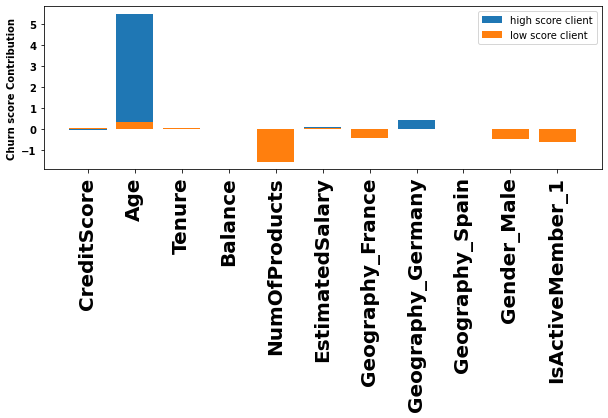

In [76]:
plt.figure(figsize=(10,3))
plt.bar( attributions_tabsra[feature_names].columns,attributions_tabsra.iloc[1883][feature_names], label ='high score client')
plt.bar( attributions_tabsra[feature_names].columns,attributions_tabsra.iloc[1134][feature_names], label ='low score client')

plt.ylabel(r'Churn score Contribution',weight = 'bold')
plt.xticks(rotation=90, weight = 'bold',fontsize=20)
plt.yticks( weight = 'bold')
plt.legend()
#plt.savefig('TabSRA_Churn_individual.png',bbox_inches='tight')
plt.show()

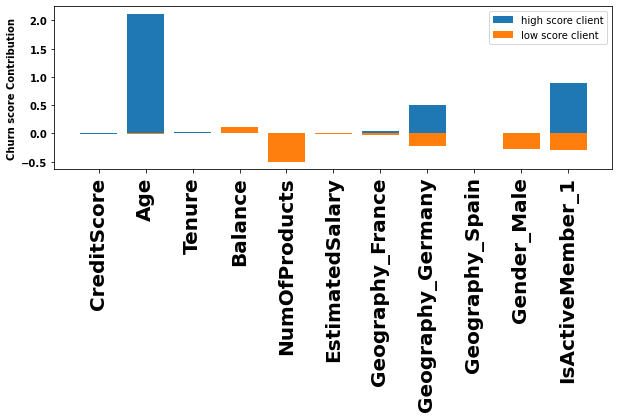

In [77]:
plt.figure(figsize=(10,3))
plt.bar( attributions_xgb[feature_names].columns,attributions_xgb.iloc[1883][feature_names], label ='high score client')
plt.bar( attributions_xgb[feature_names].columns,attributions_xgb.iloc[1134][feature_names], label ='low score client')

plt.ylabel(r'Churn score Contribution',weight = 'bold')
plt.xticks(rotation=90, weight = 'bold',fontsize=20)
plt.yticks( weight = 'bold')
plt.legend()
#plt.savefig('XGBoost_Churn_individual.png',bbox_inches='tight')
plt.show()

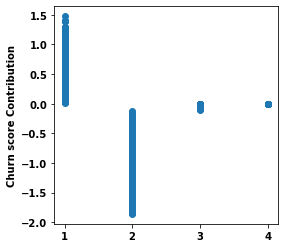

In [78]:
plt.figure(figsize=(4,4))
plt.scatter(data_test_df["NumOfProducts"],attributions_tabsra["NumOfProducts"])
plt.ylabel(r'Churn score Contribution',weight = 'bold')
plt.xticks(ticks=[1,2,3,4],rotation=0, weight = 'bold')
plt.yticks( weight = 'bold')
#plt.savefig('TabSRA_Churn_NumOfProducts.png',bbox_inches='tight')
plt.show()

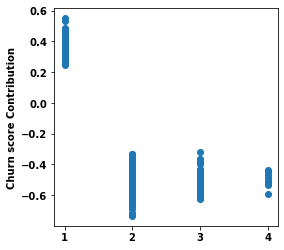

In [79]:
plt.figure(figsize=(4,4))
plt.scatter(data_test_df["NumOfProducts"],attributions_xgb["NumOfProducts"])
plt.ylabel(r'Churn score Contribution',weight = 'bold')
plt.xticks(ticks=[1,2,3,4],rotation=0, weight = 'bold')
plt.yticks( weight = 'bold')
#plt.savefig('XGBoost_Churn_NumOfProducts.png',bbox_inches='tight')
plt.show()

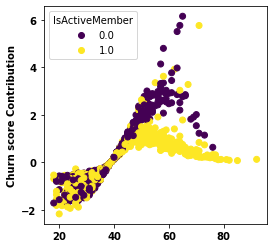

In [80]:
plt.figure(figsize=(4,4))
scatter_cat = plt.scatter(data_test_df["Age"],attributions_tabsra["Age"],c=X_test_["IsActiveMember_1"])
plt.ylabel(r'Churn score Contribution',weight = 'bold')
plt.xticks(rotation=0, weight = 'bold')
plt.yticks( weight = 'bold')
plt.legend(handles=scatter_cat.legend_elements()[0],labels = list(X_test_["IsActiveMember_1"].value_counts().sort_index().index),title="IsActiveMember")
#plt.savefig('TabSRALinear_Churn_Age.png',bbox_inches='tight')
plt.show()

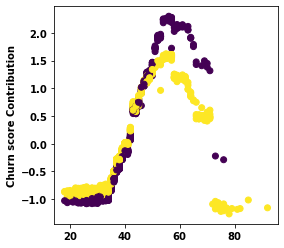

In [81]:
plt.figure(figsize=(4,4))
scatter_cat = plt.scatter(data_test_df["Age"],attributions_xgb["Age"],c=X_test_["IsActiveMember_1"])
plt.ylabel(r'Churn score Contribution',weight = 'bold')
plt.xticks(rotation=0, weight = 'bold')
plt.yticks( weight = 'bold')
#plt.savefig('XGBoost_Churn_Age.png',bbox_inches='tight')
plt.show()